
## 航空宇宙情報システム学第二

<h1><center> 第11回 制約なし関数最小化 </center> </h1>

<center>

2023年6月27日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>




# はじめに

この授業の5回目、6回目で扱った関数当てはめ（回帰）は、残差二乗和を目的関数とする最小化問題と見ることができました。また7回目で扱ったロジスティック回帰でも、対数尤度をモデルのパラメータについて最大化する問題を扱いました。

今回は、これらを包含する一般的な問題、<font color="red">制約なし関数最小化(unconstrained minimization)</font> を取り上げたいと思います。

最適化・数理計画法自体がものすごく大きな分野で、制約なし関数最小化に限っても、目的関数が微分可能かどうか、連続かどうか、下に凸かどうか、など様々な条件によって用いる手法が違って来ますが、ここでは、目的関数が連続かつ2階微分まで可能であるという前提で、基本の手法である最急降下法、ニュートン法、準ニュートン法を紹介します。




## 例題: Rosenbrock 関数

数値最適化の古典的なベンチマーク問題として知られている、Rosenbrock関数を考えてみます。Rosenbrock関数は、次式で表される2変数関数です。（注: 3変数以上の多変数に拡張したバージョンもあります。）
$$
f(x,y) = (a-x)^2 + b (y-x^2)^2
$$
$a,b$は任意の定数ですが、$a=1$, $b=100$ という値が良く使われるので、ここでもそれに従うことにします。
$$
f_{\mbox{rosen}}(x,y) = (1-x)^2 + 100 (y-x^2)^2
$$
とします。

この関数は、2つの項をそれぞれ二乗して足した形になっており、
<font color="blue">最小値を取るのは、それぞれの項が$0$になるとき、すなわち、
$x = 1, \hspace{5mm} y = x^2 = 1$ のときで、また、最小値は$0$である</font>ことが分かります。

また、第1項よりも第2項の方が係数も次数も大きく、$y=x^2$という放物線から離れた場所では支配的に大きな値を取ることが予想されます。

実際に、$(x,y)$での関数値を求めるPython関数'f_rosen'を定義し、それを使ってMatplotlibで3次元プロットを描いてみると、つぎのようになります。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Rosenbrock function
def f_rosen(x,y):
  return (1-x)**2 + 100*(y-x**2)**2


In [ ]:
dxy = 0.01
mx,my = np.meshgrid(np.arange(-2,2+dxy,dxy),np.arange(-2,3+dxy,dxy))
mz = f_rosen(mx,my)

In [ ]:
mz.shape

(501, 401)

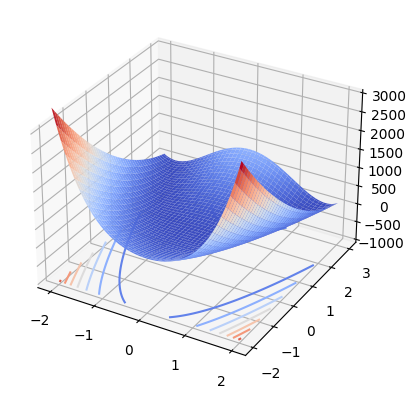

In [ ]:
dxy = 0.01
mx,my = np.meshgrid(np.arange(-2,2+dxy,dxy),np.arange(-2,3+dxy,dxy))
mz = f_rosen(mx,my)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim((-1000,3000))
ax.plot_surface(mx,my,mz,cmap=cm.coolwarm)
ax.contour(mx,my,mz,offset=-1000,cmap=cm.coolwarm)

ちょっとわかりずらいので、等高線を描いてみると次のようになります。点$(1,1)$で最小値を取り、$y=x^2$の放物線のカーブに沿っては非常になだらかで、放物線から法線方向にずれると急峻な斜面になっていることが分かります。

Text(1.0, 1.2, 'Minimum')

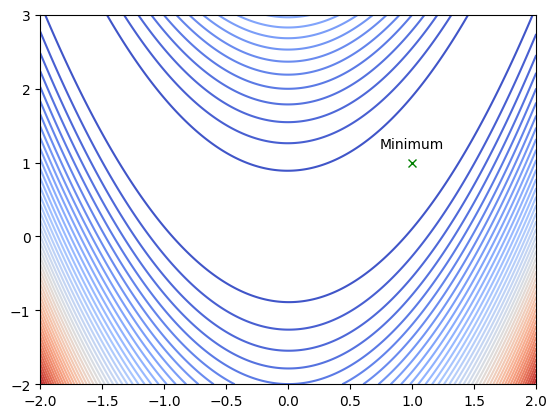

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")

## 勾配ベクトル(gradient)

Rosenblock関数の勾配ベクトル$\nabla f$は、関数を2変数$x$,$y$で偏微分すれば求まります。
$$
\nabla f = \left[
  \begin{matrix}
  \frac{\partial f}{\partial x} \\
  \frac{\partial f}{\partial y}
  \end{matrix}
  \right]
= \left[
  \begin{matrix}
  400x(x^2-y)+2(x-1) \\
  200(y-x^2)
  \end{matrix}
  \right]
$$

これも、$x,y$を引数とするPythonの関数として定義しておきます。

In [ ]:
def grad_rosen(x,y):
  dfdx = 400*x*(x**2-y)+2*(x-1)
  dfdy = 200*(y-x**2)
  return np.array([dfdx,dfdy])

2次元平面内の$-2\leq x,y \leq 2$での勾配ベクトルの向きと大きさ(に比例する値)を図示すると次のようになります。
(勾配が小さいところでは矢印の向きが分かりにくいですね。。)

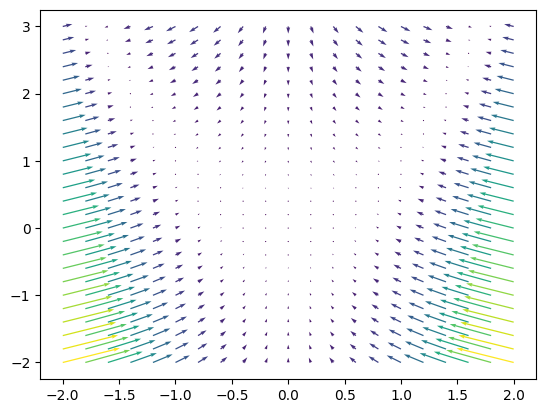

In [ ]:
dxy = 0.2
mx2,my2 = np.meshgrid(np.arange(-2,2+dxy,dxy),np.arange(-2,3+dxy,dxy))
gradvec = grad_rosen(mx2,my2)
plt.quiver(mx2,my2,-gradvec[0],-gradvec[1],np.sqrt(np.sum(gradvec**2,axis=0)))

## 最急降下法 (固定ステップ幅)

数値計算による関数最小化の基本的な考え方は、「適当な初期値から始めて、各ステップで関数値を減少させる方向(探索方向)へ移動しながら真の解に近づく」ことです。つまり、$k$ステップ目での解を$\boldsymbol{x}_k$, その地点での探索方向を表すベクトルを$\boldsymbol{d}_k$と書く時、次の$k+1$ステップでの解を、

$$
\boldsymbol{x}_{k+1} \leftarrow \boldsymbol{x}_k + \alpha_k \boldsymbol{d}_k
$$

とします。ここで、$\alpha_k > 0$を**ステップ幅**(step size)と呼びます。

まず、最も素朴な方法を考えてみると、
* 探索方向は最急降下の方向とする ($\boldsymbol{d}_k = - \nabla f(\boldsymbol{x}_k)$)。
* ステップ幅は常に一定（$\alpha_k = \alpha$）。

早速、この方針に従って、適当な初期解($(-2,-2)$)から探索してみましょう。

<font color="red"> まず、ステップ幅を$\alpha=0.0002$という非常に小さい値に設定した場合</font>です。


In [ ]:
alp = 0.0002
N = 50 # ステップ数
X = np.zeros((N,2))
fhist = np.zeros(N)
X[0,:] = [-2.0,-2.0]
fhist[0] = f_rosen(X[0,0],X[0,1])
for k in range(N-1):
  # search direction = - gradient
  dirvec = - grad_rosen(X[k,0],X[k,1])
  # next position
  X[k+1,:] = X[k,:] + alp * dirvec
  fhist[k+1] = f_rosen(X[k+1,0],X[k+1,1])
print(X)

[[-2.         -2.        ]
 [-1.0388     -1.76      ]
 [-0.80204346 -1.64643578]
 [-0.65440692 -1.5548474 ]
 [-0.54992503 -1.47552357]
 [-0.47108631 -1.40440593]
 [-0.4092066  -1.3393528 ]
 [-0.35931542 -1.27908068]
 [-0.318293   -1.22275315]
 [-0.28405047 -1.16979061]
 [-0.255121   -1.1197716 ]
 [-0.23043637 -1.07237726]
 [-0.20919611 -1.02735814]
 [-0.19078648 -0.98451329]
 [-0.17472806 -0.94367678]
 [-0.16064047 -0.90470851]
 [-0.14821796 -0.86748796]
 [-0.13721199 -0.8319097 ]
 [-0.12741861 -0.79788022]
 [-0.11866896 -0.7653156 ]
 [-0.11082226 -0.73413968]
 [-0.10376033 -0.70428283]
 [-0.09738333 -0.67568087]
 [-0.09160649 -0.64827429]
 [-0.08635745 -0.62200765]
 [-0.08157419 -0.59682904]
 [-0.07720327 -0.5726897 ]
 [-0.07319849 -0.5495437 ]
 [-0.06951977 -0.52734763]
 [-0.0661322  -0.50606041]
 [-0.06300526 -0.48564305]
 [-0.0601122  -0.46605854]
 [-0.05742952 -0.44727166]
 [-0.05493646 -0.42924887]
 [-0.05261471 -0.4119582 ]
 [-0.05044801 -0.39536914]
 [-0.04842191 -0.37945257]
 

Text(0.5, 0, 'Step')

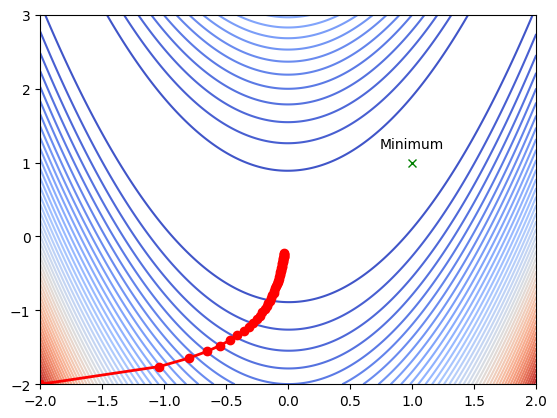

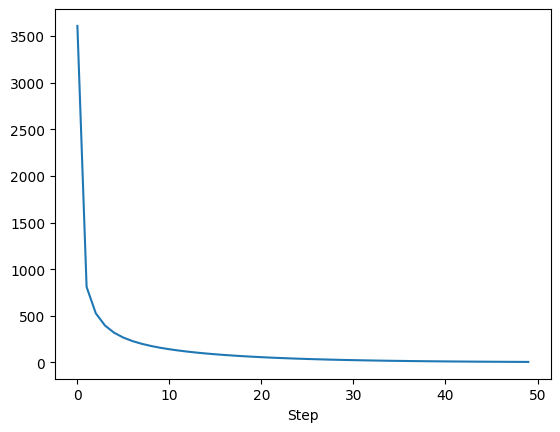

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.xlabel('Step')

勾配が非常に大きい初期ステップでは良い感じに見えますが、勾配が小さい領域に入ると立ち往生してしまい、なかなか最小値を取る地点$(1,1)$に近づきません。

そこで、ステップ幅を大きくしてみます。実際、自分で$\alpha$の値をいろいろいじって試してみてもらいたいのですが、<font color="red">少し大きくしただけでもすぐに発散してしまい、チューニングが非常に難しい</font>ことが分かります。

In [ ]:
alp = 0.0009
N = 5 # ステップ数
X = np.zeros((N,2))
fhist = np.zeros(N)
X[0,:] = [-2.0,-2.0]
fhist[0] = f_rosen(X[0,0],X[0,1])
for k in range(N-1):
  # search direction = - gradient
  dirvec = - grad_rosen(X[k,0],X[k,1])
  # next position
  X[k+1,:] = X[k,:] + alp * dirvec
  fhist[k+1] = f_rosen(X[k+1,0],X[k+1,1])
print(X)

[[ -2.          -2.        ]
 [  2.3254      -0.92      ]
 [ -2.97400196   0.21894733]
 [  6.26821993   1.77158058]
 [-78.40510764   8.52500067]]


Text(0.5, 0, 'Step')

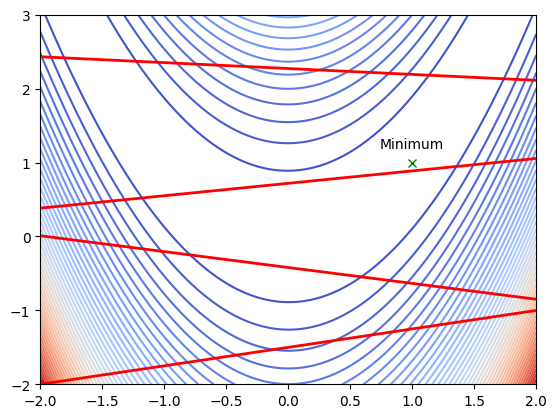

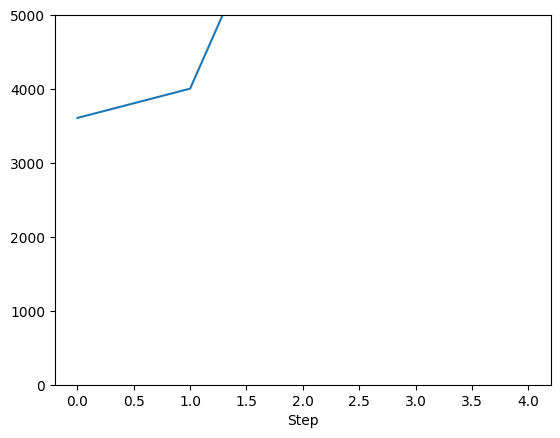

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
plt.xlim([-2,2])
plt.ylim([-2,3])
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.ylim([0,5000])
plt.xlabel('Step')

## 最急降下法 (適応ステップ幅)

固定ステップ幅では、収束が遅すぎたり発散したりと安定性に難があるので、
各ステップで、適応的にステップ幅$\alpha_k$を求めることにより、上記の問題を解決します。

Wolfeの条件、あるいは、Armijoの条件と呼ばれる以下の不等式を満たす$\alpha_k$を、バックトラック法によって求める、すなわち、大きな値から始めて条件を満たさなければ、$\alpha_k \leftarrow \rho \alpha_k$ (ただし$0<\rho<1$ )とし、満たせばそのときの$\alpha_k$を用いる方法が知られています。
$$
f(\boldsymbol{x}_k+\alpha_k \boldsymbol{d}_k) \leq f(\boldsymbol{x}_k) +c\alpha_k \nabla f(\boldsymbol{x}_k) \cdot \boldsymbol{d}_k
$$
ここで、$c$は$0<c<1$を満たす定数ですが、比較的小さい値を用いるのが一般的です。下のコードでは、$c=0.01$ , $\rho=0.5$としています。

この条件、一見難解で、どうしてこれを満たすステップ幅が良いのか分かりにくいですが、ざっくり言えば、<font color="blue">「今の関数値よりもある程度小さくなるようなステップ幅であれば許容する」</font>ということです。

気になる人は、"Armijo condition" で Google画像検索すると、わかりやすい図説が見つかると思います。



In [ ]:
# ステップ幅を探索するためのパラメータ
c = 1.0e-2
rho = 0.5

N = 50 # ステップ数
X = np.zeros((N,2))
fhist = np.zeros(N)
X[0,:] = [-2.0,-2.0]
fhist[0] = f_rosen(X[0,0],X[0,1])
for k in range(N-1):
  # search direction = - gradient
  gradvec = grad_rosen(X[k,0],X[k,1])
  dirvec = - gradvec
  fval = f_rosen(*tuple(X[k,:]))
  alp = 1.0
  # Wolfe (Armijo)条件を満たすステップ幅をバックトラック法で探す
  while True:
    if f_rosen(*tuple(X[k,:]+alp*dirvec)) - fval < c*alp*np.vdot(gradvec,dirvec):
      break
    alp *= rho
  # next position
  X[k+1,:] = X[k,:] + alp * dirvec
  fhist[k+1] = f_rosen(X[k+1,0],X[k+1,1])
print(X)

[[-2.         -2.        ]
 [ 0.34667969 -1.4140625 ]
 [-1.30527803  0.98320204]
 [-0.93338632  1.12393421]
 [-1.11012254  1.02521382]
 [-1.01616878  1.06567442]
 [-1.0345511   1.05275433]
 [-1.02348841  1.05618043]
 [-0.99193057  0.94803157]
 [-0.95633316  0.96205293]
 [-0.98416508  0.94350612]
 [-0.95713496  0.95330096]
 [-0.97730187  0.9387722 ]
 [-0.95709702  0.94515765]
 [-0.97122827  0.9337815 ]
 [-0.95631766  0.93749355]
 [-0.96582233  0.92852867]
 [-0.95491077  0.93020215]
 [-0.96096213  0.92303513]
 [-0.952992    0.92319649]
 [-0.95653304  0.91733605]
 [-0.95066933  0.91640613]
 [-0.95419647  0.90653585]
 [-0.94361453  0.90808079]
 [-0.94905037  0.90117751]
 [ 0.90871866  0.85308663]
 [ 0.92846858  0.84241592]
 [ 0.91450327  0.850087  ]
 [ 0.92467585  0.8447078 ]
 [ 0.9175166   0.84873812]
 [ 0.9227858   0.84604225]
 [ 0.91912854  0.84818732]
 [ 0.92187873  0.84686308]
 [ 0.92002517  0.84803391]
 [ 0.92147869  0.84741376]
 [ 0.92055494  0.84808142]
 [ 0.92133995  0.8478236 ]
 

Text(0.5, 0, 'Step')

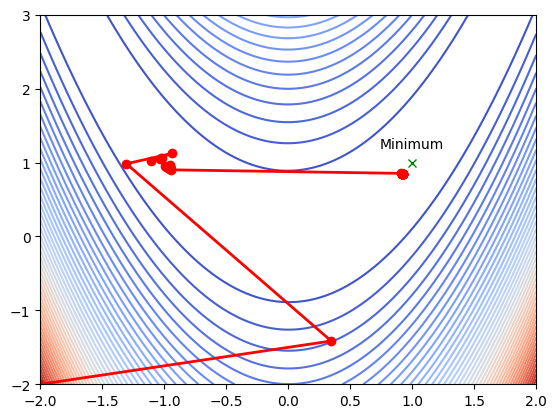

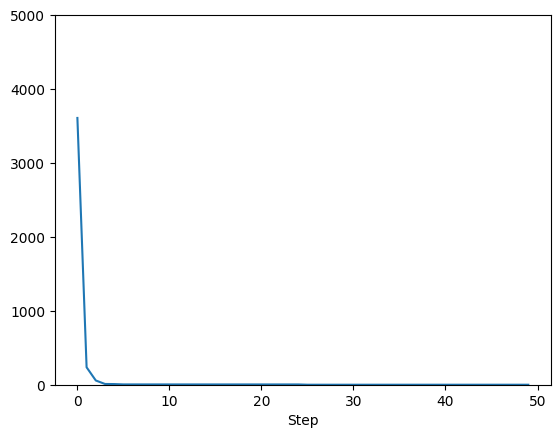

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
plt.xlim([-2,2])
plt.ylim([-2,3])
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.ylim([0,5000])
plt.xlabel('Step')

ステップ幅を適応的に決定することによって、最急勾配法が大きく改善しました。しかし、ここで満足せずに先に進みます。

## ヘッセ行列 (Hessian)

2変数関数$f(x,y)$のヘッセ行列(Hessian)は、
$$
\boldsymbol{H} = \nabla^2 f(x,y) = \left[
  \begin{matrix}
  \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
  \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
  \end{matrix}
  \right]
$$
で与えられます。Rosenbrock関数の場合を計算してみると、
$$
\boldsymbol{H} = \nabla^2 f(x,y) = \left[
  \begin{matrix}
  1200x^2 - 400 y + 2 & -400x \\
  -400x & 200
  \end{matrix}
  \right]
$$
です。下のコードは、$(x,y)$を引数としてRosenbrock関数のヘッセ行列を返す関数です。



In [ ]:
#Hesse行列
def hes_rosen(x,y):
  return np.array([[1200*x**2-400*y+2,-400*x],[-400*x,200]])

import numpy.linalg as la

## (余談) ラプラシアンとヘシアン
関数$f(x,y)$のHessian(行列)$\boldsymbol{H}=\nabla^2 f$と、Laplacian(スカラー値)$\Delta f$との間には、以下の関係があります。
$$
\Delta f(x,y) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = \mbox{tr} \left( \boldsymbol{H} \right)
$$
ここで、$\mbox{tr}$は(正方)行列のトレース、すなわち、対角成分の和を表します。

また、$\nabla$を勾配ベクトルを求める作用素とするとき、<font color="red">Laplacianは、
$$
\Delta = \nabla \cdot \nabla = \nabla^\top \nabla = \frac{\partial^2 }{\partial x^2} + \frac{\partial^2 }{\partial y^2}
$$
のように、$\nabla$同士の内積(ドット積、スカラー積)</font>であるのに対して、<font color="blue">Hessianは、
$$
\nabla^2 = \nabla \otimes \nabla = \nabla \nabla^\top =
\left[
\begin{matrix}
\frac{\partial^2 }{\partial x^2} & \frac{\partial^2 }{\partial x \partial y} \\
\frac{\partial^2 }{\partial y \partial x} & \frac{\partial^2 }{\partial y^2}
\end{matrix}
\right]
$$
のように、$\nabla$同士の外積(直積、テンソル積)</font>になっています。

LaplacianもHessianも、$\nabla^2$と表記することがありますが、両者を区別して表したいときは、
* Laplacian: $\nabla \cdot \nabla$
* Hessian: $\nabla \otimes \nabla$

と書くのが良いかもしれません。もっとも、LaplacianとHessianが同時に現れることはあまり無いので、文脈から自明な場合も多いですが。

## 関数の2次近似とNewton 法

さて、多変数関数 $f(\boldsymbol{x}+\boldsymbol{p})$を$\boldsymbol{x}$のまわりでテーラー展開し2次の項までで近似すると、ヘッセ行列を用いて、
$$
f(\boldsymbol{x}+\boldsymbol{p}) \approx f(\boldsymbol{x}) + \boldsymbol{p}^\top \nabla f + \frac{1}{2} \boldsymbol{p}^\top \boldsymbol{H} \boldsymbol{p}
$$
と表すことができます。右辺が極値を取るのは、$\boldsymbol{p}$についての１階微分が$\boldsymbol{0}$になるとき、すなわち、
$$
  \frac{\partial f}{\partial \boldsymbol{p}} = \frac{\partial}{\partial \boldsymbol{p}} \left( f(\boldsymbol{x}) + \boldsymbol{p}^\top \nabla f + \frac{1}{2} \boldsymbol{p}^\top \boldsymbol{H} \boldsymbol{p} \right) = \nabla f +  \boldsymbol{H} \boldsymbol{p} = \boldsymbol{0}
$$
より、
$$
\boldsymbol{p} = - \boldsymbol{H}^{-1} \nabla f
$$
のときです。

前式より、もしも$f(\boldsymbol{x}_k)$がTaylor展開の2次の項までで十分に近似されるのであれば、各ステップでの探索方向を、
$$
\boldsymbol{d}_k = - \boldsymbol{H}_k^{-1} \nabla f(\boldsymbol{x}_k)
$$
とすれば、一気に極小値に近づけるはずです。これがNewton法の考え方です。

大雑把な言い方をすれば、「極値を見つけたい」→「勾配がゼロになる場所を探せば良い」→「現在地点の勾配と曲率を考慮すれば、勾配ゼロの場所を予測できる」というアイデアです。図で書くと、下のようになります。<font color="blue">$\boldsymbol{x}=\boldsymbol{x}_k$において、目的関数と2次の近似関数とは傾き(勾配)だけでなく曲率(Hesse行列)も一致</font>しています。

<img src="https://drive.google.com/uc?export=view&id=1KLuS1_l-LK2y15Sw1KzefYZdlQTt2LSj" width="600"/>

Newton法では、目的関数$f(\boldsymbol{x})$が2次近似に十分近い場合は、ステップ幅は常に$\alpha = 1$で良いのですが、実際には必ずしもそうではないので、勾配法の時と同様に各ステップでの刻み幅を適応的に決めるのが一般的です。

ということで、Newton法でRoesenbrock関数を最小化するコード例が下になります。先程の場合もそうですが、本来は「収束条件」を決めてループを回しますが、ここではステップ数($N$)を決めて回しています。


In [ ]:
#Newton法(+適応ステップ幅)によるRosenbrock関数の最小化

# ステップ幅を探索するためのパラメータ
c = 1.0e-4
rho = 0.5

N = 25 # ステップ数
X = np.zeros((N,2))
fhist = np.zeros(N)
X[0,:] = [-2.0,-2.0]
fhist[0] = f_rosen(X[0,0],X[0,1])
for k in range(N-1):
  # gradient
  gradvec = grad_rosen(X[k,0],X[k,1])
  # Hesse
  Hes = hes_rosen(X[k,0],X[k,1])
  # Direction
  dirvec = - la.solve(Hes,gradvec)
  fval = f_rosen(*tuple(X[k,:]))
  alp = 1.0
  # Wolfe (Armijo)条件を満たすステップ幅をバックトラック法で探す
  while True:
    if f_rosen(*tuple(X[k,:]+alp*dirvec)) - fval < c*alp*np.vdot(gradvec,dirvec):
      break
    alp *= rho
  # next position
  X[k+1,:] = X[k,:] + alp * dirvec
  fhist[k+1] = f_rosen(X[k+1,0],X[k+1,1])
print(X)

[[-2.         -2.        ]
 [-1.99750208  3.99000833]
 [-1.62328132  2.4949956 ]
 [-1.53285243  2.34145918]
 [-1.29258733  1.60692164]
 [-1.12612091  1.24043725]
 [-0.80113596  0.53620361]
 [-0.71972149  0.5113707 ]
 [-0.53485794  0.24692724]
 [-0.36101818  0.10011387]
 [-0.16780294 -0.0091743 ]
 [-0.02986954 -0.01813343]
 [ 0.18445779 -0.01191153]
 [ 0.26451305  0.06355831]
 [ 0.425679    0.15202373]
 [ 0.50969593  0.25273109]
 [ 0.61134416  0.3598799 ]
 [ 0.71437148  0.49971198]
 [ 0.80583332  0.64100207]
 [ 0.87847185  0.76643643]
 [ 0.93760183  0.87560084]
 [ 0.97432238  0.94795571]
 [ 0.99454608  0.9887129 ]
 [ 0.99958761  0.99914996]
 [ 0.99999791  0.99999566]]


Text(0.5, 0, 'Step')

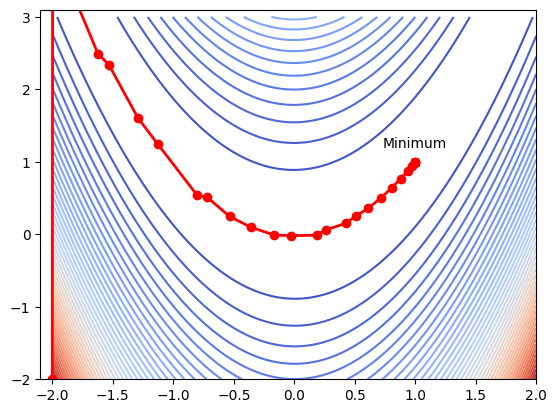

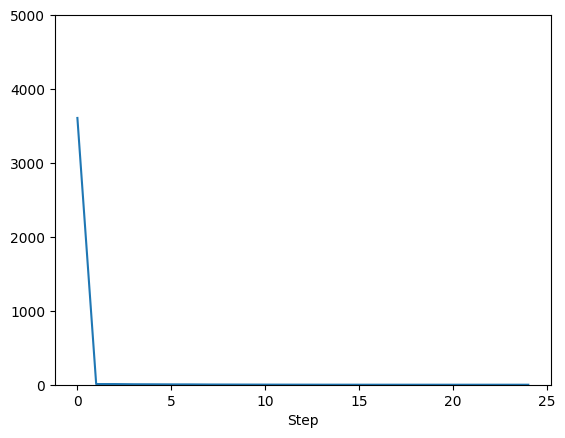

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
plt.xlim([-2.1,2])
plt.ylim([-2,3.1])
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.ylim([0,5000])
plt.xlabel('Step')

## Newton法の問題点

Newton法は、目的関数を(Taylor展開の意味で)2次近似するので、一般に、最急降下法よりも効率的で局小解への収束が速いのですが、その反面、安定性に難があります。
特に、真の局小解から遠い場所では、目的関数の2次近似が適切である保証がありません。

具体的には、ヘッセ行列$\boldsymbol{H}$が逆行列を持たないときには探索方向$\boldsymbol{d}_k$が求まらず、また、正定(positive definite)でないときには、求めた$\boldsymbol{d}_k$が関数値を却って増加させてしまう可能性があります（下の図参照）。
そのため、実際には、Newton法を「そのまま」使うことはほとんどありません。

<img src="https://drive.google.com/uc?export=view&id=1Hqcifk2n1SRdEJn6tP3j_4OM9NFcIEFo" width="600"/>


上記の問題点を一番手軽に解決する方法は、<font color="blue">ヘッセ行列$\boldsymbol{H}$が正定でないときに、単位行列の定数倍を足して、無理やり行列を正定にする</font>ことです。このとき、各ステップでの探索方向は、
$$
\boldsymbol{d}_k = -\left( \boldsymbol{H} + \tau \boldsymbol{I} \right)^{-1} \nabla f
$$
になります。
一見すると、場当たり的な方法にも見えますが、$\tau=0$の場合はNewton法に一致し、$\tau \rightarrow \infty$の場合は($\boldsymbol{H}$よりも$\boldsymbol{I}$の方が支配的になるので)最急降下法に近づく、ということが分かります。


このように「本来、正定・正則なはずの行列が非正定・非正則になってしまい逆行列が求まらない」という問題は、関数当てはめ（回帰）でも出てきました。思い出してみると、線形最小二乗法の場合、最適な係数ベクトルが、
$$
\hat{\boldsymbol{\alpha}} = \left( \boldsymbol{X}^\top \boldsymbol{X} \right)^{-1}\boldsymbol{X}^\top\boldsymbol{y}
$$
で求まりましたが、$\boldsymbol{X}^\top \boldsymbol{X}$が非正則・非正定になって逆行列が求まらないことがあります。そういう場合に、
$$
\hat{\boldsymbol{\alpha}} = \left( \boldsymbol{X}^\top \boldsymbol{X} + \lambda \boldsymbol{I} \right)^{-1}\boldsymbol{X}^\top\boldsymbol{y}
$$
として求めることは、リッジ回帰と呼ばれていました。

とりあえず、この対策をニュートン法に追加してみたのが下のコードになります。もとのコードからの変更はごく僅かです。




In [ ]:
#Newton法(Hesse行列補正+適応ステップ幅)によるRosenbrock関数の最小化

# Hessian に足し込む単位行列の係数
tau = 2.0

# ステップ幅を探索するためのパラメータ
c = 1.0e-4
rho = 0.5

N = 30 # ステップ数
X = np.zeros((N,2))
fhist = np.zeros(N)
X[0,:] = [-2.0,-2.0]
fhist[0] = f_rosen(X[0,0],X[0,1])
for k in range(N-1):
  # gradient
  gradvec = grad_rosen(X[k,0],X[k,1])
  # Hessian + tau I
  Hes = hes_rosen(X[k,0],X[k,1]) + tau*np.eye(2)
  # Direction
  dirvec = - la.solve(Hes,gradvec)
  fval = f_rosen(*tuple(X[k,:]))
  alp = 1.0
  # Wolfe (Armijo)条件を満たすステップ幅をバックトラック法で探す
  while True:
    if f_rosen(*tuple(X[k,:]+alp*dirvec)) - fval < c*alp*np.vdot(gradvec,dirvec):
      break
    alp *= rho
  # next position
  X[k+1,:] = X[k,:] + alp * dirvec
  fhist[k+1] = f_rosen(X[k+1,0],X[k+1,1])
print(X)

[[-2.00000000e+00 -2.00000000e+00]
 [-1.97802475e+00  3.85356336e+00]
 [-1.86849254e+00  3.48297296e+00]
 [-1.70268418e+00  2.87769381e+00]
 [-1.54652058e+00  2.37239184e+00]
 [-1.37664439e+00  1.87130275e+00]
 [-1.20559985e+00  1.42864139e+00]
 [-1.02757496e+00  1.02822164e+00]
 [-8.49759700e-01  6.93817324e-01]
 [-6.69312121e-01  4.18173821e-01]
 [-4.93781768e-01  2.15040859e-01]
 [-3.19280254e-01  7.29104068e-02]
 [-1.56345274e-01 -1.36124646e-03]
 [ 4.07941289e-03 -2.54782684e-02]
 [ 1.44339720e-01  8.97245876e-04]
 [ 2.84369803e-01  6.06601317e-02]
 [ 3.95075614e-01  1.43005510e-01]
 [ 5.08696505e-01  2.44844042e-01]
 [ 5.90836915e-01  3.41375895e-01]
 [ 6.72083564e-01  4.44068375e-01]
 [ 7.31875761e-01  5.31195749e-01]
 [ 7.84100776e-01  6.11285675e-01]
 [ 8.25034085e-01  6.78335210e-01]
 [ 8.58167485e-01  7.34789071e-01]
 [ 8.84649604e-01  7.81437138e-01]
 [ 9.05895633e-01  8.19811759e-01]
 [ 9.22990758e-01  8.51304765e-01]
 [ 9.36802362e-01  8.77149458e-01]
 [ 9.48007925e-01  8

Text(0.5, 0, 'Step')

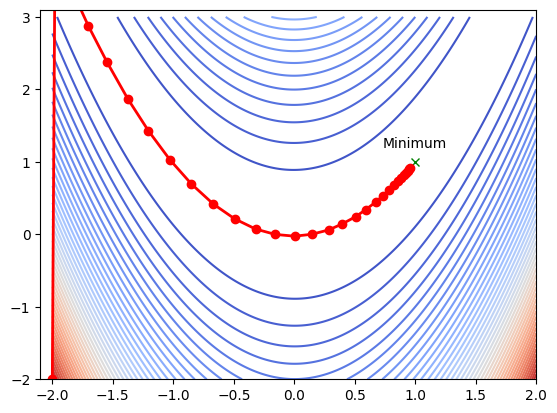

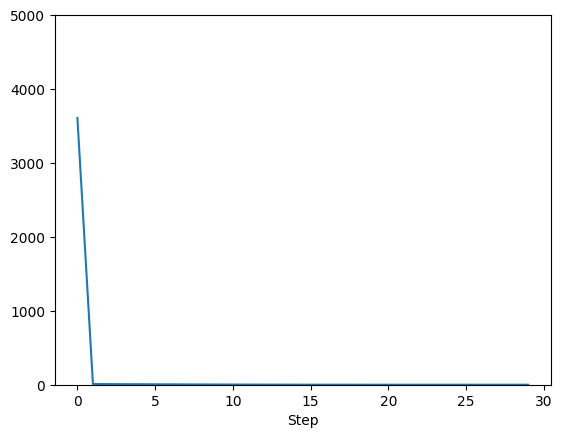

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
plt.xlim([-2.1,2])
plt.ylim([-2,3.1])
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.ylim([0,5000])
plt.xlabel('Step')

この例の場合は、Newton法よりも解への収束が遅くて微妙な結果になりましたが、Hessianの正定性を見ながら$\tau$の値を調整するようなことを行えば、勾配法の頑強性とNewton法の高速性を融合することができるはずです。

## 準ニュートン法(Quasi-Newton Method)

実際に色々な分野での制約なし最適化問題において、上で述べたニュートン法やその仲間よりも使われているのが、準ニュートン法です。ニュートン法に比べて以下の2点が嬉しいところです。
* ニュートン法ではHesse行列を直接計算する必要があるが、準ニュートン法ではステップを重ねるごとにHesse行列の近似が自動的に求まっていく。
* ニュートン法ではHesse行列が正定である保証が無いが、準ニュートン法では正定性を保ったままHesse行列の近似を求めることができるので、より安定である。

準ニュートン法の中にも色々なアルゴリズムが存在しますが、代表的かつ人気の手法のひとつ、BFGS(Broyden–Fletcher–Goldfarb–Shanno)法は次のようになります。
(詳細は、[Wikipediaの解説](https://ja.wikipedia.org/wiki/BFGS%E6%B3%95)などを参照してください。。)

0. 初期解$\boldsymbol{x}_0$と、Hesse行列の初期近似$\boldsymbol{\tilde{H}}_0$を定める。(単位行列で始めるケース、すなわち、$\boldsymbol{\tilde{H}}_0=\boldsymbol{I}$とするのが一般的)。$k \leftarrow 0$ とする。

以下を収束するまで繰り返す
1. 現在のステップでの探索方向$\boldsymbol{d}_k$を以下により求める。
$$
\boldsymbol{d}_k =- \boldsymbol{\tilde{H}}_k^{-1} \nabla f(\boldsymbol{x}_k)
$$
2. ステップ幅$\alpha_k$をニュートン法などと同様に決める。
3. 次式により、次のステップの解を求める。
$$
\begin{align}
\boldsymbol{s}_k &= \alpha_k \boldsymbol{d}_k \\
\boldsymbol{x}_{k+1} &= \boldsymbol{x}_{k} + \boldsymbol{s}_k
\end{align}
$$
4. 次の解での勾配を計算し、現在の勾配との差を求める。すなわち、
$$
\boldsymbol{y}_k = \nabla f(\boldsymbol{x}_{k+1}) - \nabla f(\boldsymbol{x}_k)
$$
5. 次式により、Hesse行列の近似を更新する。
$$
\boldsymbol{\tilde{H}}_{k+1} = \boldsymbol{\tilde{H}}_k + \frac{\boldsymbol{y}_k \boldsymbol{y}_k^\top}{\boldsymbol{s}_k^\top \boldsymbol{y}_k}
- \frac{(\boldsymbol{\tilde{H}}_k \boldsymbol{s}_k)(\boldsymbol{\tilde{H}}_k \boldsymbol{s}_k)^\top}{\boldsymbol{s}_k^\top \boldsymbol{\tilde{H}}_k \boldsymbol{s}_k}
$$
6. $k \leftarrow k+1$として、1に戻る。

<font color="red">言うまでもなく、手順5のHesse行列の近似の更新が肝心なのですが、とても複雑なのでどうしてそうなるのかは割愛します。</font>ただ、更新式の右辺第２項、第３項ともに、分子はベクトルの外積で行列、分母はベクトルの内積でスカラーになっている点に注意してください。

なお、この準ニュートン法の実装では、Hesse行列$\boldsymbol{H}_k$を逐次近似していますが、<font color="blue">Hesse行列の逆行列$\boldsymbol{H}_k^{-1}$を直接逐次近似する実装</font>もあります（というか、そちらの方が主流）。

In [ ]:
#Quasi-Newton法(BFGSアルゴリズム)によるRosenbrock関数の最小化

# ステップ幅を探索するためのパラメータ
c = 1.0e-4
rho = 0.5

# 最大ステップ数
mxstp = 30
#N = 30 # ステップ数
X = [np.array([-2.0,-2.0])]
fhist = [f_rosen(X[0][0],X[0][1])]
# gradient
gradvec = grad_rosen(X[0][0],X[0][1])
# Hessianの近似。最初は単位行列で初期化
Hes = np.eye(2)
for k in range(N-1):
  print("Iteration {:d}".format(k))
  # Direction
  dirvec = - la.solve(Hes,gradvec)
  fval = f_rosen(X[k][0],X[k][1])
  alp = 1.0
  # Wolfe (Armijo)条件を満たすステップ幅をバックトラック法で探す
  while True:
    print(alp,end=" ")
    if f_rosen(*tuple(X[k]+alp*dirvec)) - fval < c*alp*np.vdot(gradvec,dirvec):
      break
    elif alp < 1.0e-6:
      print("too small alpha ?")
      break
    alp *= rho
  # next position
  sk = alp * dirvec
  X.append(X[k] + sk)
  fhist.append(f_rosen(X[k+1][0],X[k+1][1]))
  # 現在の場所での勾配を退避
  gradpre = gradvec.copy()
  # 次の場所での勾配
  gradvec = grad_rosen(X[k+1][0],X[k+1][1])
  # 勾配の変化
  yk = gradvec - gradpre
  Hs = np.dot(Hes,sk)
  # Hessian近似の更新
  Hes+= np.outer(yk,yk)/np.vdot(sk,yk)-np.outer(Hs,Hs)/np.vdot(sk,Hs)

# array の list を 2D arrayに変換
X = np.array(X)
fhist = np.array(fhist)
print(np.hstack((X,fhist.reshape((-1,1)))))

Iteration 0
1.0 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 Iteration 1
1.0 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 Iteration 2
1.0 Iteration 3
1.0 Iteration 4
1.0 Iteration 5
1.0 Iteration 6
1.0 Iteration 7
1.0 Iteration 8
1.0 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 0.0001220703125 6.103515625e-05 3.0517578125e-05 1.52587890625e-05 7.62939453125e-06 3.814697265625e-06 1.9073486328125e-06 9.5367431640625e-07 too small alpha ?
Iteration 9
1.0 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 0.0001220703125 6.103515625e-05 3.0517578125e-05 1.52587890625e-05 7.62939453125e-06 3.814697265625e-06 1.9073486328125e-06 9.5367431640625e-07 too small alpha ?
Iteration 10
1.0 0.5 0.25 0.125 0.0625 0.03125 0.015625 0.0078125 0.00390625 0.001953125 0.0009765625 0.00048828125 0.000244140625 0.0001220

Text(0.5, 0, 'Step')

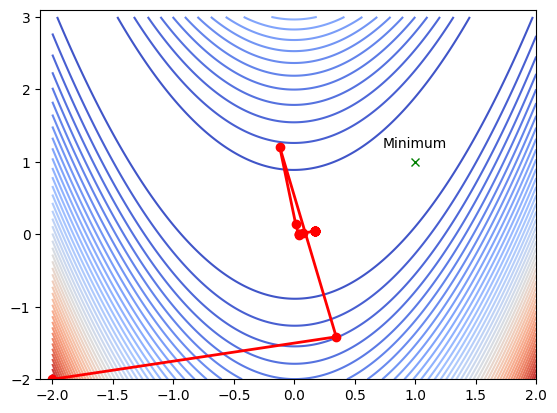

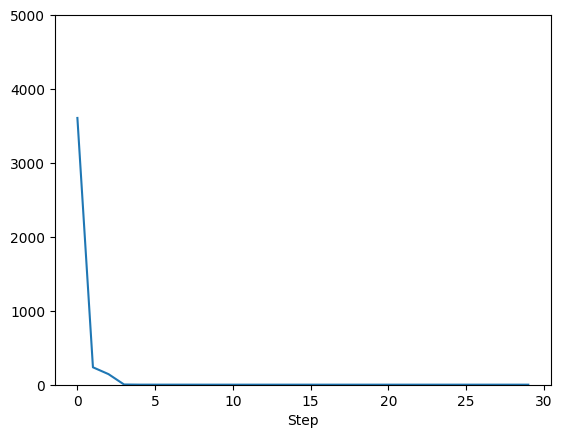

In [ ]:
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# 軌跡
plt.plot(X[:,0],X[:,1],'ro-',lw=2)
plt.xlim([-2.1,2])
plt.ylim([-2,3.1])
# 関数の値の履歴
plt.figure()
plt.plot(fhist)
plt.ylim([0,5000])
plt.xlabel('Step')

ええっと、難しいことをやっている割には、結果は微妙でした。。実装がイマイチだからかもしれません。。まあ、こういうこともあります。

## scipy.optimize.minimize の利用

今回は勉強と練習のために敢えて、最急降下法、Newton法, 準ニュートン法を(中途半端ながらも)実装しました。
しかし、本格的に最適化のプログラミングが必要になった場合には、scipyなどのモジュール・ライブラリを利用することをお薦めします(常微分方程式の場合もそうですが)。

Scipy の optimizeサブモジュールに含まれている`minimize`関数では、準Newton法以外にも、共役勾配法(Conjugate Gradient Method)やPowell法など、様々な最適化アルゴリズムを選択することができ、制約条件も扱うことができます。

ここでは、これを使って、準ニュートン法(BFGSアルゴリズム)、共役勾配法でRosenbrock関数を最小化してみます。

In [ ]:
from scipy.optimize import minimize

# Roesenbrock関数とその勾配を計算する関数の引数を minimize関数用に書き換え
f_rosen2 = lambda x: f_rosen(*list(x))
grad_rosen2 = lambda x: grad_rosen(*list(x))

# 初期解
x0 = np.array([-2.0, -2.0])

# BFGS
print('Mnimization by Quasi-Newton (BFGS) algorithm')
res_bfgs = minimize(f_rosen2, x0, method='BFGS', jac=grad_rosen2, options={'disp': True, 'return_all': True})
print('Solution: x=',res_bfgs.x)
print('\n')

# 共役勾配法 (CG)
print('Minimization by Conjugate Gradient method')
res_cg = minimize(f_rosen2,x0,method='CG', jac=grad_rosen2, options={'disp': True, 'return_all': True})
print('Solution: x=',res_cg.x)


Mnimization by Quasi-Newton (BFGS) algorithm
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 73
         Gradient evaluations: 73
Solution: x= [1. 1.]


Minimization by Conjugate Gradient method
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 44
         Gradient evaluations: 43
Solution: x= [1. 1.]


(-2.0, 3.1)

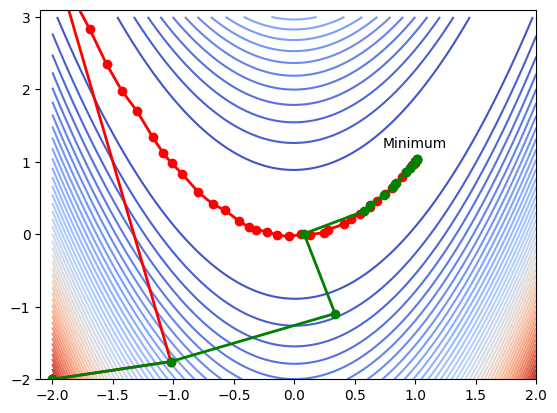

In [ ]:
X_bfgs = np.array(res_bfgs.allvecs)
X_cg = np.array(res_cg.allvecs)
plt.contour(mx,my,mz,cmap=cm.coolwarm,levels=50)
plt.plot(1.0,1.0,'gx')
plt.text(1.0,1.0+0.2,'Minimum',ha="center")
# BFGS軌跡
plt.plot(X_bfgs[:,0],X_bfgs[:,1],'ro-',lw=2)
# CG軌跡
plt.plot(X_cg[:,0],X_cg[:,1],'go-',lw=2)
plt.xlim([-2.1,2])
plt.ylim([-2,3.1])
